# **Иследование данных  HR-агенства**

## 1. Постановка задачи

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

2. Ответить на ключевые вопросы HR-агентства:
+ Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
+ Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
+ Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
+ Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
+ Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

3. Продемонстрировать использование разных тестов для проверки статистической значимости сделанных выводов:
+ тесты для количественного признака:
+ для одной выборки;
+ для двух выборок;
+ для нескольких выборок;
+ тест для категориальных признаков.



#### *Описание столбцов:*
+ **work_year**	Год, в котором была выплачена зарплата.
+ **experience_level**	Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
+ **employment_type**	Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
+ **job_title**	Роль, в которой соискатель работал в течение года.
+ **salary**	Общая выплаченная валовая сумма заработной платы.
+ **salary_currency**	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
+ **salary_in_usd**	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
+ **employee_residence**	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
+ **remote_ratio**	Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
+ **company_location**	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
+ **company_size**	Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

## 2. Загрузка и предварительный анализ

In [2]:
#импортируем библиотеки необходимые для работы 
import pandas as pd
import numpy as np
import dtale

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu, kruskal
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns



# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [3]:
#загружаем датасет 
data= pd.read_csv('ds_salaries.csv', index_col=[0])
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
#задаем уровень значимости для дальнейшей работы 
alpha= 0.05
print('Уровень значимости alpha = {:.2f}'.format(alpha))

Уровень значимости alpha = 0.05


In [5]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

In [6]:
#для первичного анализа перед очитской базы детально знакомимся с данными через  библиотеку dtale
d= dtale.show(data)
#d.open_browser()

## 3. Очистка данных

In [7]:
#проверяем датасет на наличие пропусков 
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


        - Датасет не имеет пропусков

### **Удаление неинформативных признаков, дубликатов**

In [8]:
#проверяем данные на неинформативные признаки
data.describe(include= "all")


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,607.000000,607,607,607,6.070000e+02,607,607.000000,607,607.00000,607,607
unique,NaN,4,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,SE,FT,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,280,588,143,NaN,398,NaN,332,NaN,355,326
mean,2021.405272,NaN,NaN,NaN,3.240001e+05,NaN,112297.869852,NaN,70.92257,NaN,NaN
std,0.692133,NaN,NaN,NaN,1.544357e+06,NaN,70957.259411,NaN,40.70913,NaN,NaN
min,2020.000000,NaN,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.00000,NaN,NaN
25%,2021.000000,NaN,NaN,NaN,7.000000e+04,NaN,62726.000000,NaN,50.00000,NaN,NaN
50%,2022.000000,NaN,NaN,NaN,1.150000e+05,NaN,101570.000000,NaN,100.00000,NaN,NaN
75%,2022.000000,NaN,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.00000,NaN,NaN


In [9]:
#проверяем на неиформативные признаки
low_information_cols= []

#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота 
    top_freq= data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio= data[col].nunique() / data[col].count()
    #сравниваем наибольшую частоту с порогом
    if top_freq> 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100)}% одинаковых значений')
    if nunique_ratio>0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100)}% уникальных значений')        
        
        

employment_type: 97% одинаковых значений


In [10]:
#удаляем неинформативные признаки 
data=data.drop(low_information_cols,axis=1)

data=data.drop(['salary','salary_currency'],axis=1)
print(f'Результирующее число признаков: {data.shape[1]}')

Результирующее число признаков: 8


        - Неинформативными признаками в нашем анализе на данным момент является признак salary (общая сумма выплаченной ЗП), так же salary_currency (валюта в которой выплачивается заработная плата).
        - Признак employement_type -  так же является не информативных ,  так как имеет 97% одинаковых  значений.


 На признаки **employee_residence** и **company_location**,  так же стоит обратить внимание,  так как страна в которой находится компания часто совпадает со странной в которой проживает сотрудник.\
 Необходимо провести дополнительный анализ  и при необходимости удалить данные из  датасета.


In [11]:
# проверяем наличие дубликатов
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 42


In [12]:
data= data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Размер таблицы после удаления дубликатов: (565, 8)


In [13]:
# Проводим доп.анализ  признаков 'company_location', 'employee_residence' 
# Это покажет количество дубликатов, но не удалит их
duplicated_mask = data.duplicated(subset=['company_location', 'employee_residence']).sum()
prosent_dubl= round((duplicated_mask / data.shape[0])* 100)
prosent_uninque =round(((len(data) - duplicated_mask)/ data.shape[0])* 100)
print(f"Количество дубликатов: {duplicated_mask}. {prosent_dubl}% от общего количества")
print(f"Количество уникальных: {len(data) - duplicated_mask}. {prosent_uninque}% от общего количества")


Количество дубликатов: 475. 84% от общего количества
Количество уникальных: 90. 16% от общего количества


In [14]:
data= data.drop(['employee_residence'] , axis=1)
data.shape

(565, 7)

### **Датасет имеет:**
+ 607 записей (без пропущенных значений)

+ 4 неинформативных признака
    - Unnamed: 0: 100% уникальных значений
    - employment_type: 97% одинаковых значений
    - salary, salary_currency  этот признак, будет избыточным, тк как используем стандартизированную зарплату в долларах США (salary_in_usd). Включение и валюты, и конвертированной суммы может внести в модель ненужный шум
    - employee_residence и company_location -  данные имеют в себе 84% одинаковых  значений. Данный признак не несет в себе информативности и будет нагружать модель для обучения. Один из признаков необходимо удалить


+ 42 дубликата 

**После очисти данных  мы имееи итоговый размер таблицы: (565, 7)**

In [15]:
# считаем уникальное кол-во признаков по столбцам
result=(data.nunique().count)
result

<bound method Series.count of work_year             3
experience_level      4
job_title            50
salary_in_usd       369
remote_ratio          3
company_location     50
company_size          3
dtype: int64>

## 4. Визуализация

###  *4.1 Общее распределение зарплат к годам*


d:\idi\.venv\lib\site-packages\seaborn\_base.py:1601: UserWarning:

Horizontal orientation ignored with only `y` specified.



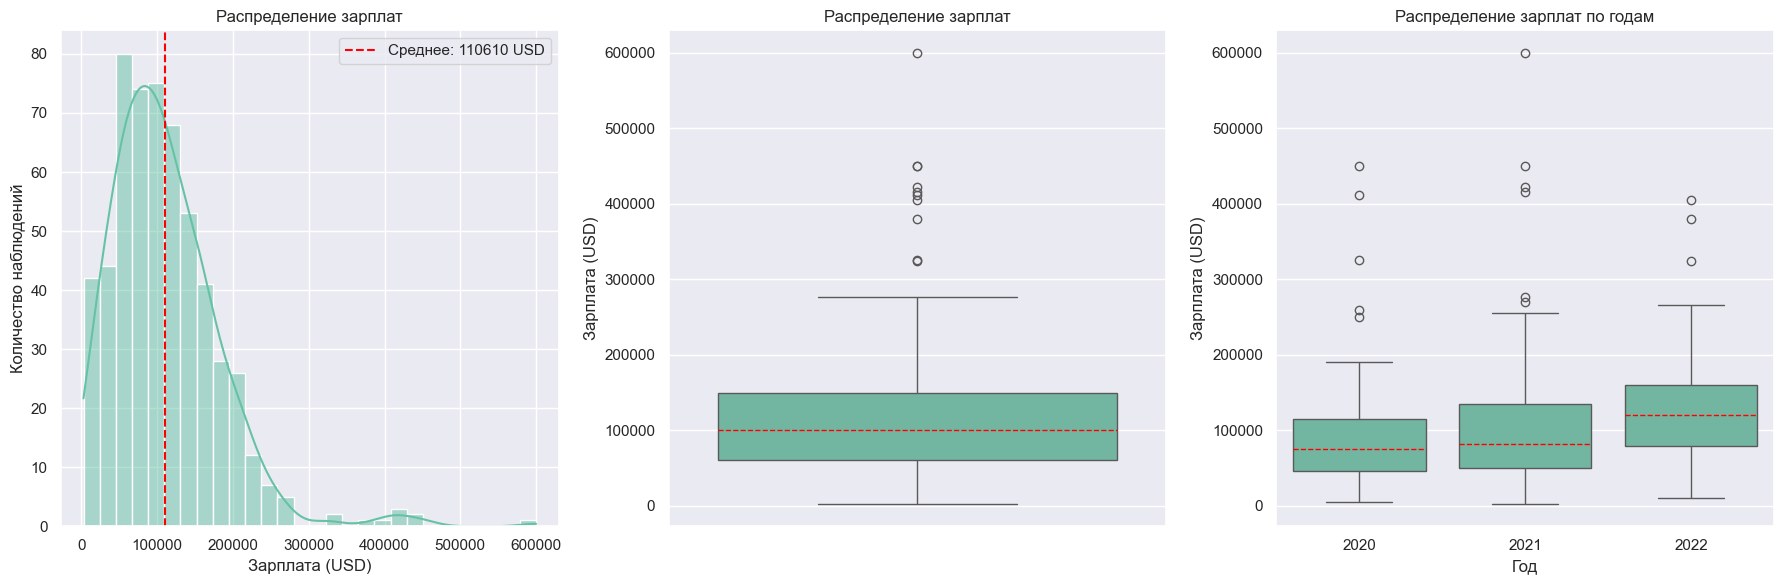

In [16]:

# Создаем сетку графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Первый график: распределение зарплат (гистограмма)
sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=1.5, 
                label=f'Среднее: {data["salary_in_usd"].mean():.0f} USD')
axes[0].set_xlabel('Зарплата (USD)')
axes[0].set_ylabel('Количество наблюдений')
axes[0].set_title('Распределение зарплат')
axes[0].legend()

# Второй график: распределение зарплат (ящик с усами)
sns.boxplot(y=data['salary_in_usd'], ax=axes[1] , orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set_title('Распределение зарплат')
axes[1].set_ylabel('Зарплата (USD)')
axes[1].set_xlabel('')

# Третий график: распределение зарплат по годам
sns.boxplot(data=data, x='work_year', y='salary_in_usd', ax=axes[2], medianprops={"color": "red", "linestyle": '--'})
axes[2].set_title('Распределение зарплат по годам')
axes[2].set_ylabel('Зарплата (USD)')
axes[2].set_xlabel('Год')

# Автоматическая регулировка layout
plt.tight_layout()
plt.show()

In [17]:
agg_data= data['salary_in_usd'].describe().round(2).to_frame()
agg_data


,salary_in_usd
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


In [18]:
agg_data_2 =  data.groupby('work_year')['salary_in_usd'].describe().round(2)
agg_data_2_transposed = agg_data_2.T
agg_data_2_transposed

work_year,2020,2021,2022
count,72.0,215.00,278.00
mean,95813.0,99430.41,123089.10
std,82831.8,80304.32,59888.93
min,5707.0,2859.00,10000.00
25%,45724.5,50000.00,78791.00
50%,75544.0,82528.00,120000.00
75%,115526.0,135000.00,160000.00
max,450000.0,600000.00,405000.00


#### **Выводы по визуальному анализу  общего распределения зарплат к годам**

#### 1. **Распределение зарплат скошено вправо (положительная асимметрия)**
- Средняя зарплата (110 610 USD) выше медианы (100 000 USD), что указывает на асимметрию.
- Высокооплачиваемые сотрудники "тянут" среднее значение вверх.
- Основная масса зарплат сосредоточена между 25% и 75% перцентилями (60 757 – 150 000 USD).

---

#### 2. **Два пика в распределении**
- На графике видны два выраженных пика:
  - Около **80 000 USD** 
  - Около **100 000 USD**
- Это показывает разделение на уровни:
  - **Middle-специалисты** (~80 000 USD)
  - **Senior-специалисты** (~100 000 USD и выше)

---

#### 3. **Значительный разброс зарплат**
- Стандартное отклонение (72 280 USD) действительно велико.
- Диапазон от 2 859 USD до 600 000 USD отражает сильную дифференциацию по опыту, специализации и размеру компании.

---

#### 4. **75% перцентиль (150 000 USD) существенно выше медианы**
- Это нормально для скошенного распределения и показывает, что верхние 25% зарплат значительно превышают медиану.
- Подтверждает наличие высокооплачиваемой группы специалистов.

---
#### 5. **Динамика по годам показывает важные тенденции** ✅ **Ваши дополнения верны:**

##### **Рост рынка:**
- Количество записей с заработной платой увеличивается с годами: **72 (2020) → 215 (2021) → 278 (2022)**
- Это свидетельствует о **росте популярности сферы DataScience** и увеличении доступности данных о зарплатах.

##### **Стабилизация зарплат:**
- **Стандартное отклонение снижается**: 82 832 (2020) → 80 304 (2021) → 59 889 (2022)
- Это указывает на **большую предсказуемость и стабильность** зарплатного рынка к 2022 году.

##### **Значительный рост оплаты труда в 2022:**
- **Медиана выросла на 45%**: 75 544 (2020) → 120 000 (2022)
- **Средняя зарплата выросла на 28%**: 95 813 (2020) → 123 089 (2022)
- В 2022 году медиана и среднее значение почти сравнялись, что говорит о **более сбалансированном распределении**.

##### **Сужение диапазона крайних значений:**
- Минимальная зарплата **выросла** с 2 859 USD (2021) до 10 000 USD (2022)
- Максимальная зарплата **снизилась** с 600 000 USD (2021) до 405 000 USD (2022)
- Это свидетельствует о **сокращении крайних значений** и большей стандартизации зарплат.

---

#### **Итоговые выводы:**

1. **Рынок демонстрирует зрелость**: от большого разброса в 2020-2021 к большей стабильности в 2022 году.

2. **Наблюдается значительный рост оплаты труда**: особенно заметный скачок произошел в 2022 году.

3. **Структура зарплат становится более прозрачной**: с четким разделением на уровни специалистов.

4. **Исчезают экстремально низкие зарплаты**, что может говорить о повышении стандартов отрасли.

5. **Данные отражают общемировую тенденцию**: рост спроса на IT-специалистов и увеличение их доходов в пост-пандемийный период.

Это типичная картина для развивающегося рынка, который проходит этап становления и стандартизации.

### *4.2 Распределение зарплат по годам для специалистов сферы DataScience*


d:\idi\.venv\lib\site-packages\seaborn\_base.py:1601: UserWarning:

Horizontal orientation ignored with only `y` specified.

C:\Users\Admin\AppData\Local\Temp\ipykernel_12076\2940615537.py:24: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



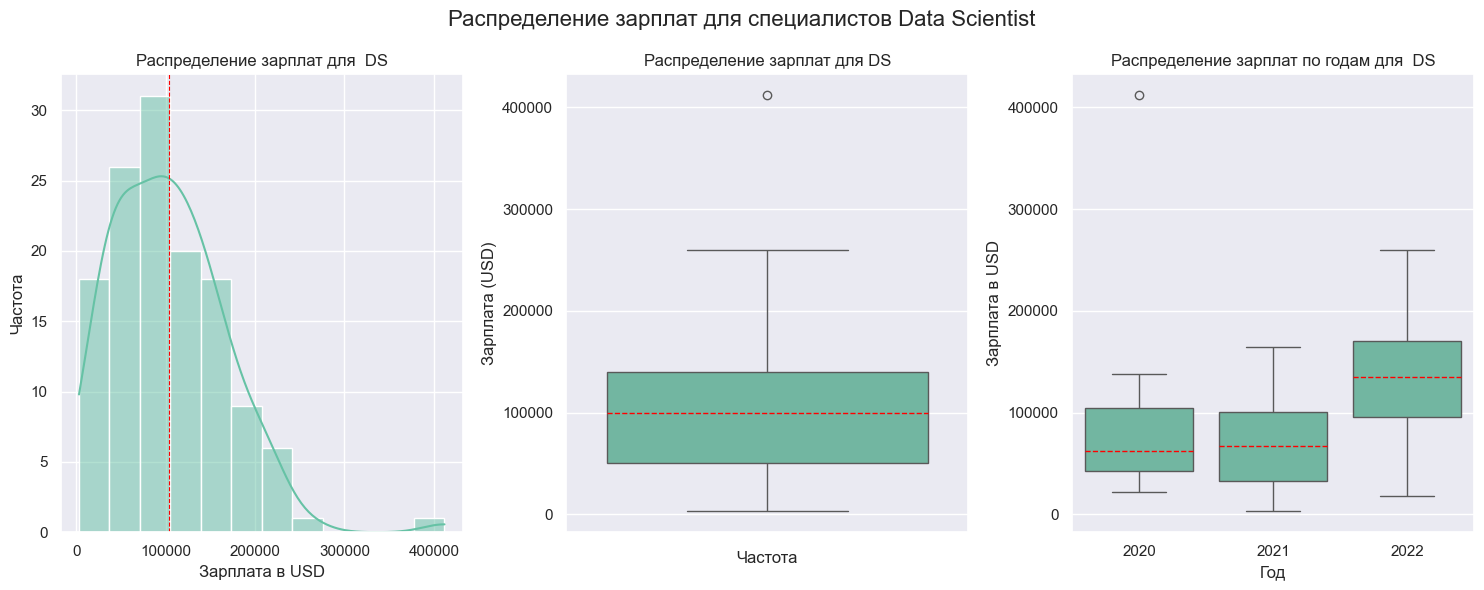

In [19]:
# Ежегодный рост зарплат для 'Data Scientist'
#делаем выботку с 
data_salary= data[data['job_title']== 'Data Scientist']
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.histplot(data_salary['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set_xlabel('Зарплата в USD')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение зарплат для  DS')
axes[0].axvline(data_salary['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8, 
                label=f'Среднее: {data_salary["salary_in_usd"].mean():.2f}')

sns.boxplot(y=data_salary['salary_in_usd'], ax=axes[1] , orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set_ylabel('Зарплата (USD)')
axes[1].set_xlabel('Частота')
axes[1].set_title('Распределение зарплат для DS')

sns.boxplot(x='work_year', y='salary_in_usd', data=data_salary,  medianprops={"color": "red", "linestyle": '--'})
axes[2].set_title('Распределение зарплат по годам для  DS')
axes[2].set_ylabel('Зарплата в USD')
axes[2].set_xlabel('Год')
plt.suptitle('Распределение зарплат для специалистов Data Scientist', fontsize=16) 
# Настраиваем отступы между графиками
plt.tight_layout()
fig.show()


In [20]:
data_agg_ds= data_salary['salary_in_usd'].describe().round(2).to_frame()
data_agg_ds

,salary_in_usd
count,130.00
mean,103336.35
std,63967.56
min,2859.00
25%,50330.25
50%,100000.00
75%,140400.00
max,412000.00


In [21]:
data_agg_2 =  data_salary.groupby('work_year')['salary_in_usd'].describe().round(2)
data_agg_2 = data_agg_2.T
data_agg_2

work_year,2020,2021,2022
count,21.00,44.00,65.00
mean,85970.52,70215.77,131366.94
std,81436.65,45843.82,55785.24
min,21669.00,2859.00,18442.00
25%,42197.00,32793.75,95550.00
50%,62726.00,67233.50,135000.00
75%,105000.00,100922.75,170000.00
max,412000.00,165000.00,260000.00


In [22]:
#посмотрим расспределение без  выбросов, судя  по графику выше,  они начинаются примерно с 280 000
data_not_Outliers= data_salary[data_salary['salary_in_usd'] < 280000]
data_agg_3 =  data_not_Outliers.groupby('work_year')['salary_in_usd'].describe().round(2)
data_agg_3=data_agg_3.T
data_agg_3

work_year,2020,2021,2022
count,20.00,44.00,65.00
mean,69669.05,70215.77,131366.94
std,33268.11,45843.82,55785.24
min,21669.00,2859.00,18442.00
25%,41768.00,32793.75,95550.00
50%,62726.00,67233.50,135000.00
75%,94677.75,100922.75,170000.00
max,138350.00,165000.00,260000.00


#### **Выводы по визуальному анализу распределения зарплат по годам**

#### 1. **Значительный рост медианной зарплаты в 2022 году**
- Данные показывают **взрывной рост медианной зарплаты (более чем в 2 раза)** за два года:
    - **2020:** 62 726 USD
    - **2021:** 67 233.5 USD
    - **2022:** 135 000 USD
- Это гораздо более резкий скачок, чем предполагалось ранее, и он указывает на резкое увеличение стоимости специалистов на рынке в 2022 году.

#### 2. **Рост среднего значения (mean) подтверждает общий тренд, но с нюансом**
- Средняя зарплата также демонстрирует рост, особенно заметный в 2022 году:
    - **2020:** 85 970.52 USD
    - **2021:** 70 215.77 USD
    - **2022:** 131 366.94 USD
- **Важное наблюдение:** В 2021 году средняя зарплата была **ниже**, чем в 2020, что могло быть связано с большим количеством новых специалистов на рынке (количество записей выросло с 21 до 44), что временно "снизило" планку. Однако к 2022 году рынок скорректировался, и зарплаты резко пошли вверх.

#### 3. **Стабилизация рынка и снижение разброса (стандартного отклонения)**
- **Стандартное отклонение (std)** существенно снизилось к 2022 году:
    - **2020:** 81 436.65 (очень высокий разброс)
    - **2021:** 45 843.82 (значительное снижение)
    - **2022:** 55 785.24 (умеренный рост на фоне увеличения зарплат, но ниже пика 2020 года)
- Это подтверждает ваш вывод о большей предсказуемости рынка. Особенно показательно сравнение 2020 и 2022 годов: при гораздо более высоких зарплатах в 2022 году разброс значений остался ниже.

#### 4. **Анализ данных без выбросов (data_agg_3) уточняет картину**
- После фильтрации зарплат выше 280 000 USD картина для 2020 года меняется:
    - **Среднее значение за 2020 год падает** с 85 970 до 69 669 USD, а **стандартное отклонение резко снижается** с 81 436 до 33 268 USD.
    - Это означает, что в 2020 году наличие всего **одной высокой зарплаты (412 000 USD)** сильно искажало общую статистику для небольшой выборки (21 запись). Реальное распределение зарплат среди большинства специалистов в 2020 году было более сконцентрированным и низким.
- Для 2021 и 2022 годов фильтрация не изменила статистики (кроме 2021 года, где max стал 165k), что говорит об отсутствии экстремальных выбросов в эти периоды и большей репрезентативности данных.

#### 5. **Сужение диапазона зарплат и рост минимального уровня**
- **Минимальная зарплата:**
    - **2021:** 2 859 USD (аномально низкое значение)
    - **2022:** 18 442 USD (более адекватный минимум)
- **Максимальная зарплата (без выбросов):**
    - **2020:** 138 350 USD
    - **2021:** 165 000 USD
    - **2022:** 260 000 USD
- Это указывает на **повышение "пола"** зарплат (исчезновение экстремально низких предложений) и одновременный **рост "потолка"** для основной массы специалистов.

---

#### **Итоговые выводы**

1.  **Качественный скачок в 2022 году:** Рынок Data Science совершил резкий рывок в 2022 году, что выразилось в более чем двукратном росте медианной зарплаты по сравнению с 2020-2021 годами. Это говорит о резком повышении спроса и ценности специалистов.

2.  **Ранний рынок (2020) был нестабильным:** Данные за 2020 год основаны на малой выборке и сильно искажались единичными экстремальными значениями. Реальный рынок для большинства был скромнее.

3.  **Корректировка 2021 года:** Рост количества данных в 2021 году, возможно, отразил приток новых кадров, что временно сдерживало рост средних зарплат, но рынок готовился к скачку.

4.  **Зрелость и стандартизация:** Снижение стандартного отклонения и рост минимальных зарплат к 2022 году свидетельствуют о формировании более зрелого, стандартизированного и прозрачного рынка с четкими "вилками" для разных уровней специалистов.

5.  **Подтверждение тренда:** Несмотря на расхождения в абсолютных цифрах, общая тенденция, описанная вами — **рост, стабилизация и повышение стандартов** — полностью подтверждается данными.





#### **Ответ на 1 вопрос HR-агенства: "Наблюдается ли ежегодный рост зарплат у специалистов DS"**
Из данных  выше  **нельзя сделать однозначный вывод о ежегодном росте**.

Данные показывают: 

####  **Что говорит против ежегодного роста:**

**2020 → 2021: Зарплаты не выросли, а скорее снизились**
- Средняя зарплата: 85,971 USD → 70,216 USD (**-18%**)
- Медианная зарплата: 62,726 USD → 67,234 USD (**+7%**, но это очень скромно)

Это указывает на возможную **коррекцию рынка** в 2021 году после "перегрева" 2020 года.

#### **Что говорит за общий рост:**

**2021 → 2022: Мощный скачок**
- Средняя зарплата: 70,216 USD → 131,367 USD (**+87%**)
- Медианная зарплата: 67,234 USD → 135,000 USD (**+100%**)

#### **Итоговый вывод:**

Наблюдается **не линейный ежегодный рост, а двухэтапная динамика**:

1. **2020-2021**: Стагнация/коррекция (возможно, из-за притока новых специалистов)
2. **2021-2022**: Резкий скачок (удвоение зарплат)


Как итог, наблюдается значительный рост зарплат специалистов DS за период 2020-2022 годов, однако этот рост был неравномерным и произошел преимущественно за счет резкого увеличения в 2022 году.

Если бы был **ежегодный рост**, мы бы видели последовательное увеличение показателей каждый год, но здесь картина более сложная.


### *4.3 Соотношение зарплаты Data Scientist и Data Engineer за 2022 год*

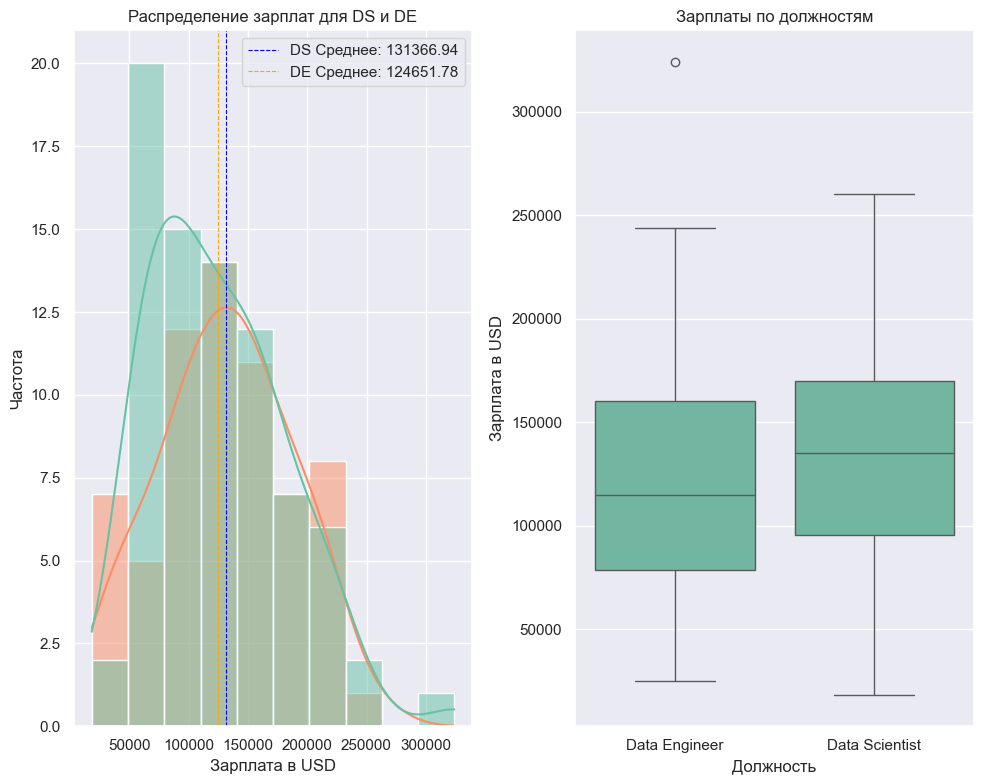

In [23]:

# Фильтруем данные: оставляем только Data Scientist и Data Engineer за 2022 год
filtered_df = data[((data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')) & (data['work_year'] == 2022)].copy()

# Строим графики 
fig, axes = plt.subplots(1, 2, figsize=(10, 8))  

# Первый график - гистограмма распределения зарплат
sns.histplot(data=filtered_df, x='salary_in_usd', hue='job_title', 
             kde=True, ax=axes[0])  
axes[0].set_xlabel('Зарплата в USD')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение зарплат для DS и DE')

# Добавляем средние значения для каждой профессии
mean_ds = filtered_df[filtered_df['job_title'] == 'Data Scientist']['salary_in_usd'].mean()
mean_de = filtered_df[filtered_df['job_title'] == 'Data Engineer']['salary_in_usd'].mean()

axes[0].axvline(mean_ds, color='blue', linestyle='--', linewidth=0.8, 
                   label=f'DS Среднее: {mean_ds:.2f}')
axes[0].axvline(mean_de, color='orange', linestyle='--', linewidth=0.8, 
                   label=f'DE Среднее: {mean_de:.2f}')
axes[0].legend()

# Второй график - boxplot
sns.boxplot(data=filtered_df, x='job_title', y='salary_in_usd', ax=axes[1])
axes[1].set_xlabel('Должность')
axes[1].set_ylabel('Зарплата в USD')
axes[1].set_title('Зарплаты по должностям')



# Настраиваем отступы между графиками
plt.tight_layout()
# Показываем график
plt.show()


In [24]:
data_agg_4_1 =  filtered_df.groupby('job_title')['salary_in_usd'].describe().round(2)
data_agg_4_1 = data_agg_4_1.T
data_agg_4_1


job_title,Data Engineer,Data Scientist
count,79.00,65.00
mean,124651.78,131366.94
std,57846.84,55785.24
min,25000.00,18442.00
25%,78526.00,95550.00
50%,115000.00,135000.00
75%,160040.00,170000.00
max,324000.00,260000.00


In [25]:
# если смотреть данные без  выбросов DE
noy_Outliers =  filtered_df[filtered_df['salary_in_usd'] < 300000]
data_agg_4_2 =  noy_Outliers.groupby('job_title')['salary_in_usd'].describe().round(2)
data_agg_4_2 = data_agg_4_2.T
data_agg_4_2


job_title,Data Engineer,Data Scientist
count,78.00,65.00
mean,122096.04,131366.94
std,53544.36,55785.24
min,25000.00,18442.00
25%,78526.00,95550.00
50%,114000.00,135000.00
75%,160000.00,170000.00
max,243900.00,260000.00



#### **Выводы по соотношению зарплат DE и DS в 2022 году не учитывая выбросы**

#### 1. **Незначительное лидерство Data Scientist по средней зарплате**
- **Data Scientist:** 131 367 USD
- **Data Engineer:** 122 096 USD
- **Разница:** +7.6% в пользу DS

Несмотря на формальное лидерство Data Scientist, разница в средних зарплатах составляет менее 10 000 USD, что указывает на **сравнимый уровень оплаты** этих специалистов.

---

#### 2. **Более высокие медианные зарплаты у Data Scientist**
- **Медиана DS:** 135 000 USD
- **Медиана DE:** 114 000 USD  
- **Разница:** +18.4% в пользу DS

**Ключевой вывод:** Медианная зарплата DS существенно выше. Это означает, что "типичный" Data Scientist зарабатывает значительно больше "типичного" Data Engineer.

---

#### 3. **Разное распределение зарплат по квантилям**

**Нижний квантиль (25%):**
- DS: 95 550 USD
- DE: 78 526 USD
- **Разница:** +21.7% в пользу DS

**Верхний квантиль (75%):**
- DS: 170 000 USD
- DE: 160 000 USD
- **Разница:** +6.25% в пользу DS

**Важное наблюдение:** Наибольшая разница в зарплатах наблюдается **на стартовых позициях** (25-й перцентиль). В верхней части вилки (75-й перцентиль) разница минимальна.

---

#### 4. **Схожий разброс зарплат**
- **Стандартное отклонение DS:** 53 785 USD
- **Стандартное отклонение DE:** 53 544 USD

Практически идентичный разброс указывает на **схожую структуру рынка** для обеих профессий с аналогичной дифференциацией по опыту и квалификации.

---

#### 5. **Более высокий "потолок" зарплат у Data Scientist**
- **Максимальная зарплата DS:** 260 000 USD
- **Максимальная зарплата DE:** 243 900 USD

Data Scientist имеют несколько более высокий потенциал заработка на верхних позициях.

---

#### **Итоговые выводы:**

1. **Data Scientist в среднем получают больше**, особенно на младших и средних позициях (разница в медиане и 25-м перцентиле составляет 18-22%).

2. **На высоких позициях разница минимальна** (всего 6% в 75-м перцентиле), что говорит о выравнивании зарплат для senior-специалистов.

3. **Обе профессии имеют схожую структуру рынка** с идентичным разбросом зарплат, что указывает на одинаковый уровень дифференциации внутри каждой профессии.

4. **Разница в зарплатах не является кардинальной** - оба специалиста находятся в одной весовой категории на рынке труда 2022 года.

5. **Более высокие зарплаты DS могут быть связаны** с:
   - Большим спросом на ML-специалистов
   - Более высокой ответственностью за бизнес-результаты
   - Относительной новизной и "модностью" профессии


#### Ответ на вопрос HR-агенства(Как соотносятся зарплаты для Data Scientist и Data Engineer за 2022 год)**

 Data Scientist имеют небольшое, но стабильное преимущество в зарплатах, особенно на начальных и средних позициях, однако для senior-уровня разница практически стирается.

### *4.4 Соотношение зарплаты специалистов Data Scientist в компаниях различных размеров*

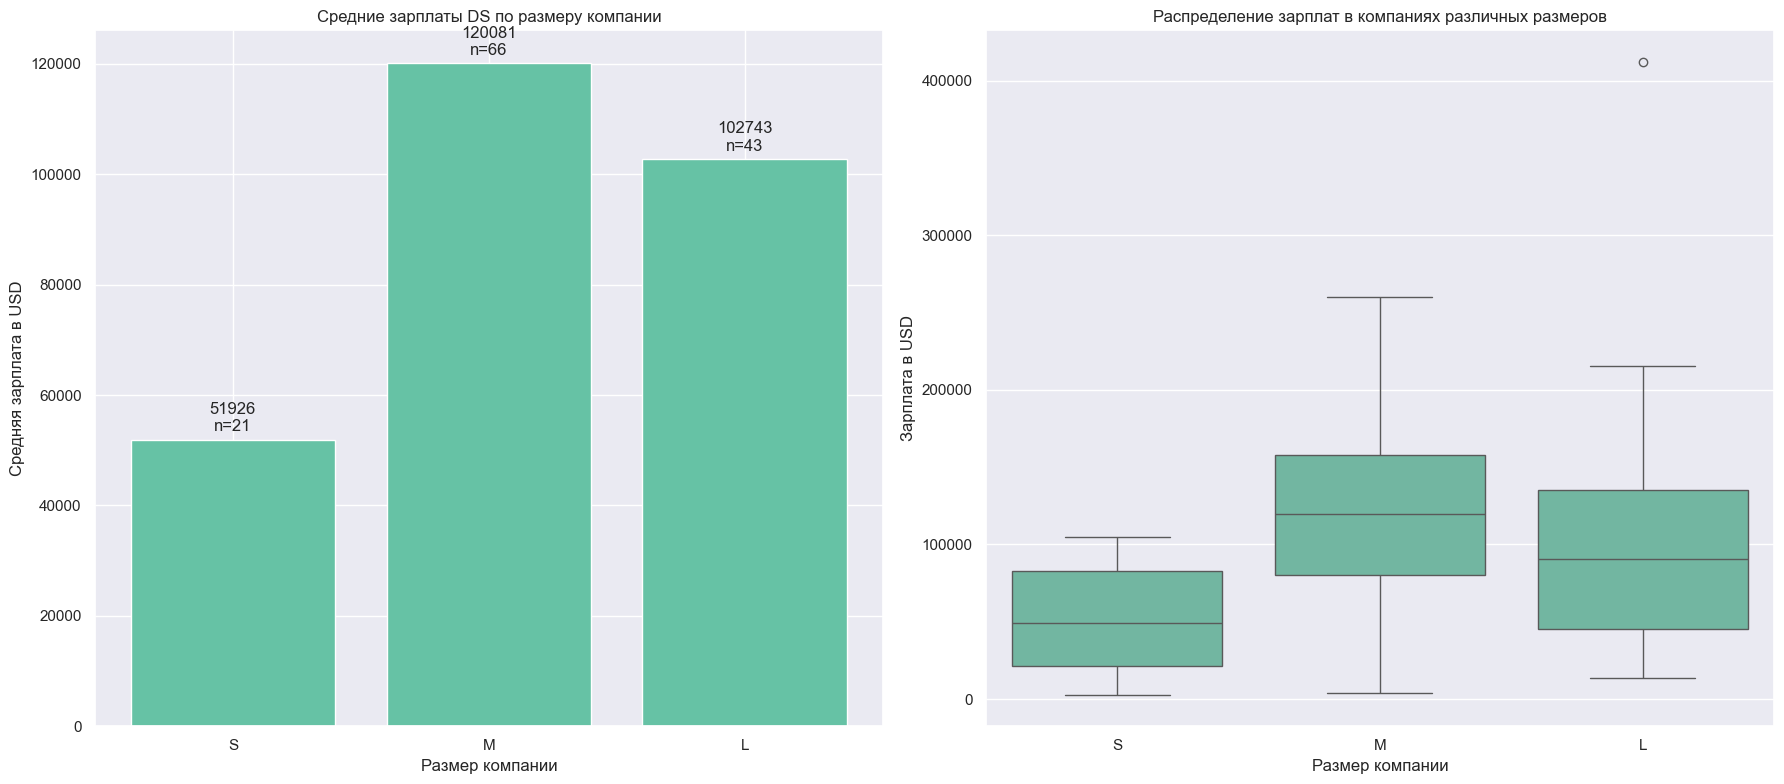

In [26]:
# Соотношение Data Scientist в компаниях различных размеров
data_DS= data[data['job_title']== 'Data Scientist']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
size_order = ['S', 'M', 'L']

# Первый график - средние зарплаты
size_stats = data_DS.groupby('company_size')['salary_in_usd'].agg(['mean', 'count']).loc[size_order]

bars = ax1.bar(size_stats.index, size_stats['mean'])
ax1.set(title='Средние зарплаты DS по размеру компании', 
        ylabel='Средняя зарплата в USD', 
        xlabel='Размер компании')

# Добавляем подписи на столбцы
for i, (mean, count) in enumerate(zip(size_stats['mean'], size_stats['count'])):
    ax1.text(i, mean + 1000, f'{mean:.0f}\nn={count}', ha='center', va='bottom')

# Второй график - распределение зарплат
sns.boxplot(x='company_size', y='salary_in_usd', data=data_DS, order=size_order, ax=ax2)
ax2.set(title='Распределение зарплат в компаниях различных размеров',
        ylabel='Зарплата в USD', 
        xlabel='Размер компании')

plt.tight_layout()
plt.show()

#### **Ответ на вопрос HR-агенства:**
                Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?


#### 1. **Неожиданная закономерность**
Средние компании платят Data Scientist больше всех - на 22% больше, чем крупные компании, и в 2.4 раза больше, чем маленькие.

#### 2.**Парадокс размера и оплаты**
Маленькие компании (S): Низкие зарплаты (ограниченные ресурсы)

Средние компании (M): Наивысшие зарплаты (зона максимального роста)

Крупные компании (L): Зарплаты ниже средних (возможно, насыщение рынка)

#### 3. **Возможные объяснения:**
+ Для средних компаний:

    - Активная фаза роста и Digital-трансформации

    - Острая конкуренция за ограниченных специалистов с крупными компаниями

    - Готовы платить премию за таланты, которые могут обеспечить конкурентное преимущество

+ Для крупных компаний:

    - Устоявшиеся процессы и структуры зарплат

    - Больший пул кандидатов, что снижает необходимость в премиальных выплатах

    - Возможно, больше focus на стабильности, а не на агрессивном росте

+ Для маленьких компаний:

    - Ограниченные бюджеты

    - Меньшая сложность задач

    - Возможно, более низкие требования к опыту

### *4.5 Наличие связи между должностями Data Scientist и Data Engineer и размером компании*

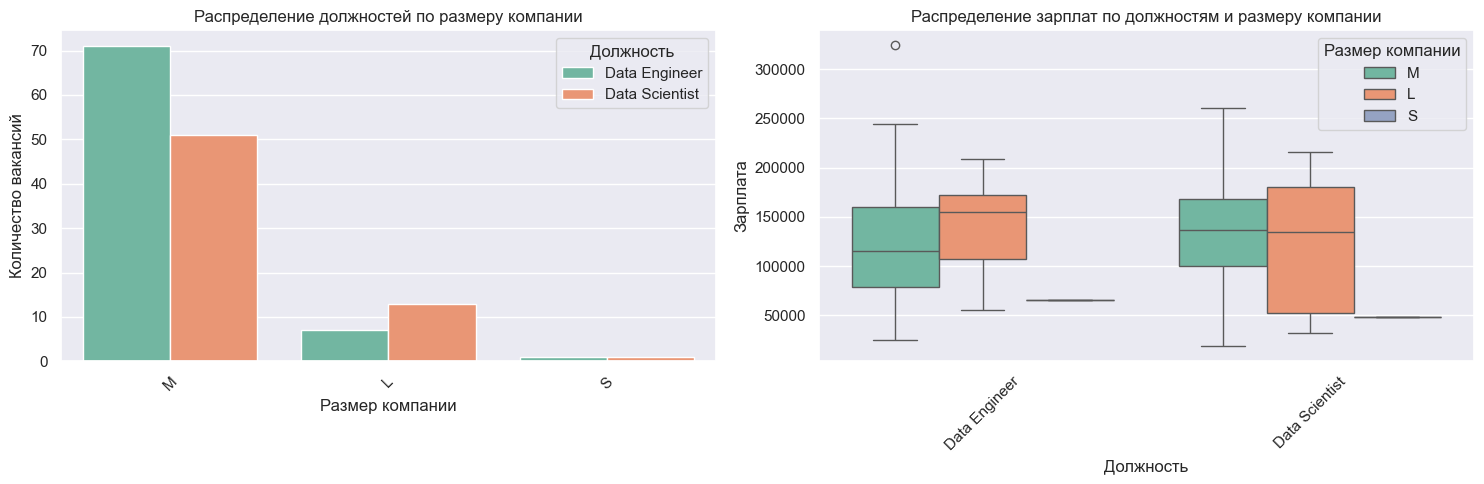

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Первый график - countplot по компаниям
sns.countplot(data=filtered_df, x='company_size', hue='job_title', ax=axes[0])
axes[0].set_xlabel('Размер компании')
axes[0].set_ylabel('Количество вакансий')
axes[0].set_title('Распределение должностей по размеру компании')
axes[0].tick_params(axis='x', rotation=45)  # Поворот подписей если нужно
axes[0].legend(title='Должность')

# Второй график - boxplot (но нужно указать числовую переменную для y)
# Предположим, что у вас есть числовая переменная, например 'salary' или 'experience'
sns.boxplot(data=filtered_df, x='job_title', y='salary_in_usd', hue='company_size', ax=axes[1])  # замените 'salary' на вашу числовую переменную
axes[1].set_xlabel('Должность')
axes[1].set_ylabel('Зарплата')  # или другая метка для числовой переменной
axes[1].set_title('Распределение зарплат по должностям и размеру компании')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Размер компании')



plt.tight_layout()
plt.show()

In [28]:
data_agg_5= filtered_df.groupby('job_title')['company_size'].describe().round().T
data_agg_5

job_title,Data Engineer,Data Scientist
count,79,65
unique,3,3
top,M,M
freq,71,51


#### **Выводы по наличию связи должностей Data Scientist и Data Engineer и размером компании**


#### 1. **Распределение должностей по размеру компании**
- **Data Engineer** и **Data Scientist** представлены в компаниях разного размера, но с явным перекосом:
  - **Data Engineer**: подавляющее большинство работает в компаниях **среднего размера (M)** — 71 из 79 человек.
  - **Data Scientist**: также преобладают в компаниях среднего размера, но распределение более сбалансировано по сравнению с Data Engineer.

- **Вывод**:  
  Средние компании активнее нанимают специалистов по данным (особенно Data Engineer), чем маленькие (S) или крупные (L) компании.

---

#### 2. **Распределение зарплат по должностям и размеру компании**
- Зарплаты варьируются в зависимости от должности и размера компании:
  - **Data Scientist** в среднем получает больше, чем **Data Engineer**, особенно в крупных компаниях (L).
  - В компаниях среднего размера (M) зарплаты ниже, чем в крупных, но выше, чем в маленьких (S).

- **Вывод**:  
  Крупные компании готовы платить больше за обе должности, но особенно за Data Scientist.  
  Средние компании предлагают умеренные зарплаты, но нанимают больше всего специалистов.

---

- **Вывод**:  
  Профессия Data Engineer  и Data Scientist сильно привязаны к среднему бизнесу. Это может быть связано с тем, что такие компании уже выросли до уровня, где нужна инженерная поддержка данных, но ещё не имеют огромных распределённых команд, как в крупных корпорациях.

---

#### Итоговые наблюдения:
- **Средние компании** — основной работодатель для Data Engineer и Data Scientist.
- **Крупные компании** платят больше, но нанимают меньше.
- **Data Scientist** в среднем имеет более высокую зарплату, особенно в больших компаниях.
- **Data Engineer** сильно сконцентрированы в среднем сегменте рынка.

#### Ответ на вопрос HR-агенства 
                Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Да, связь между наличием должностей Data Scientist/Data Engineer и размером компании явно прослеживается.**

На основе визуального анализа данных можно выделить следующие закономерности:

#### 1. **Явная концентрация в средних компаниях**
- **71 из 79 Data Engineer** (около 90%) работают в компаниях среднего размера (M)
- Data Scientist также наиболее представлены в средних компаниях, хотя распределение более сбалансировано
- **Вывод**: средние компании являются основным работодателем для этих специалистов

#### 2. **Разный уровень зарплат в зависимости от размера компании**
- Крупные компании (L) платят значительно больше обеим должностям
- Средние компании (M) предлагают умеренные зарплаты, но нанимают больше всего специалистов
- Маленькие компании (S) имеют наименьшее представительство и более низкие зарплаты

#### 3. **Причины такой связи**
- **Средние компании** уже выросли до уровня, когда нужны отдельные data-специалисты, но еще не имеют разветвленных data-отделов как крупные корпорации
- **Крупные компании** могут позволить себе更高的 зарплаты, но нанимают меньше специалистов из-за более строгого отбора
- **Маленькие компании** часто не имеют достаточных объемов данных или бюджета для содержания отдельных data-ролей

**Таким образом, размер компании является значимым фактором, определяющим как наличие должностей Data Scientist/Data Engineer, так и уровень их оплаты.**

    

### *4.6 Распределение зарплат и опыта к размеру компании для специалистов DS*

Text(0.5, 1.0, 'Медианные зарплаты (Barplot)')

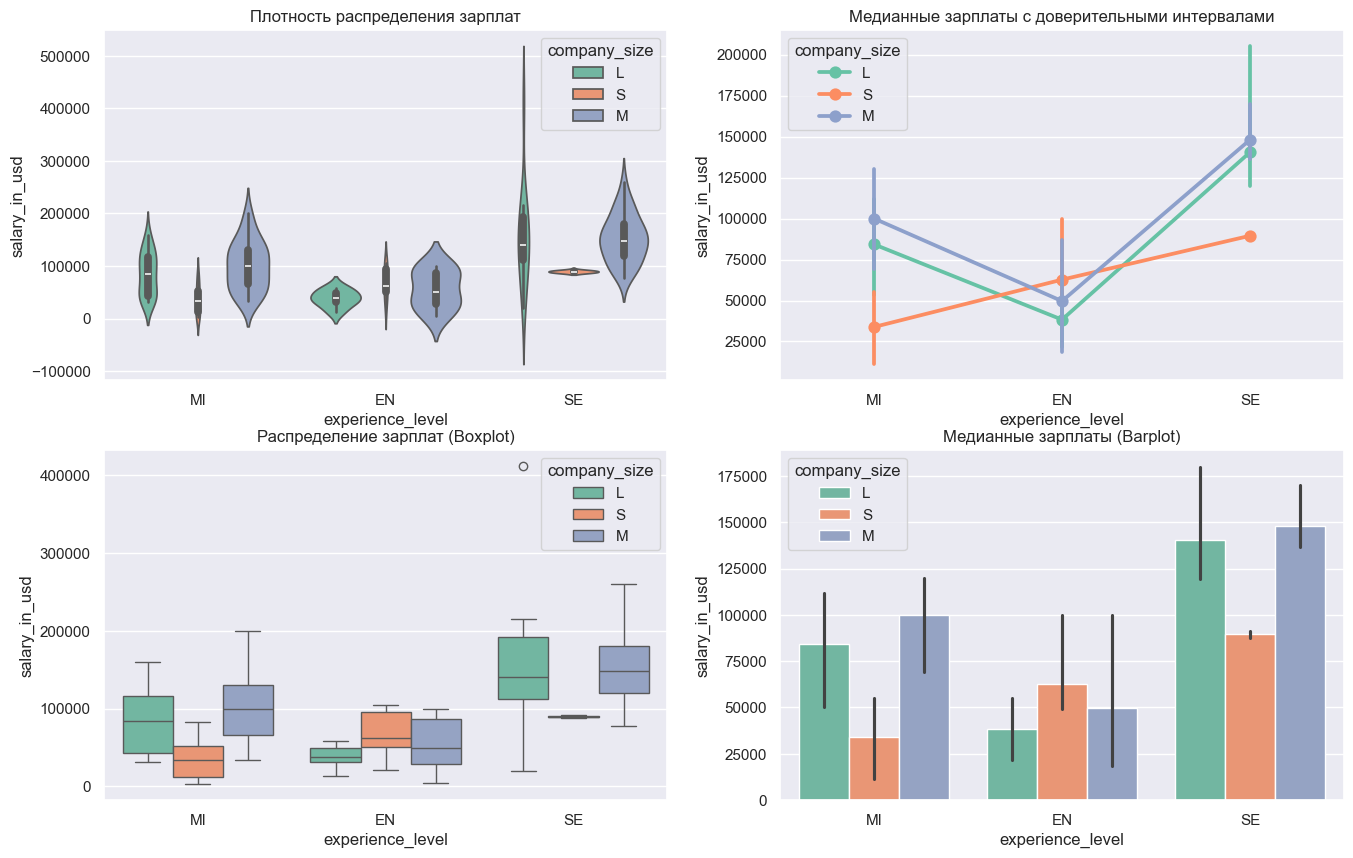

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
data_DS= data[data['job_title']== 'Data Scientist']
# 1. Violin plot + boxplot
sns.violinplot(data=data_DS, x='experience_level', y='salary_in_usd', 
              hue='company_size', ax=axes[0,0])
axes[0,0].set_title('Плотность распределения зарплат')

# 2. Pointplot с доверительными интервалами
sns.pointplot(data=data_DS, x='experience_level', y='salary_in_usd', 
             hue='company_size', estimator='median', ax=axes[0,1])
axes[0,1].set_title('Медианные зарплаты с доверительными интервалами')

# 3. Boxplot
sns.boxplot(data=data_DS, x='experience_level', y='salary_in_usd', 
           hue='company_size', ax=axes[1,0])
axes[1,0].set_title('Распределение зарплат (Boxplot)')

# 4. Barplot
sns.barplot(data=data_DS, x='experience_level', y='salary_in_usd', 
           hue='company_size', estimator=np.median, ax=axes[1,1])
axes[1,1].set_title('Медианные зарплаты (Barplot)')

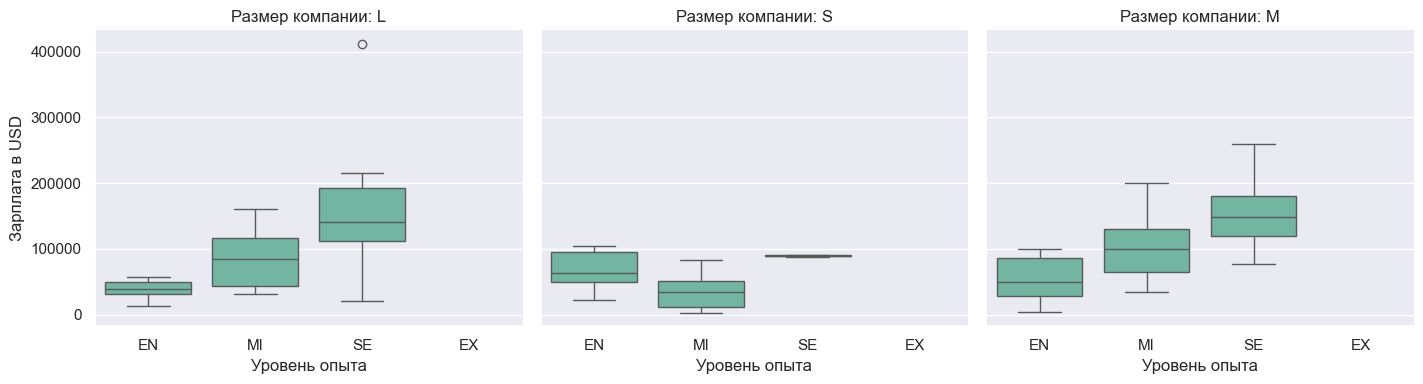

In [30]:
# FacetGrid для разделения по размеру компании
g = sns.FacetGrid(data_DS, col='company_size', height=4, aspect=1.2)
g.map(sns.boxplot, 'experience_level', 'salary_in_usd', order=['EN', 'MI', 'SE', 'EX'])
g.set_titles('Размер компании: {col_name}')
g.set_axis_labels('Уровень опыта', 'Зарплата в USD')
plt.tight_layout()

In [31]:
# Сводная таблица для наглядности 
styled_stats = (data_DS.groupby(['experience_level', 'company_size'])['salary_in_usd']
                .describe()
                .round(2)
                .style
                .background_gradient(cmap='Blues')
                .format({'mean': '${:,.0f}', 'std': '${:,.0f}', 'min': '${:,.0f}', 'max': '${:,.0f}'}))

display(styled_stats)

#### **На основе Визуального анализа выше, можно сделать следующие ключевые выводы:**
1. **Влияние опыта на зарплату (самый сильный фактор)**
- **EN → MI**: Средняя зарплата растет в **2-3 раза** (с $38-68k до $86-101k)
- **MI → SE**: Рост еще в **1.5-2 раза** (до $152-154k в средних и крупных компаниях)
- **Вывод**: Опыт является определяющим фактором оплаты труда


2. **Влияние размера компании (неоднозначно)**

#### **Для Junior (EN) специалистов**:
- **Парадокс**: Маленькие компании (S) платят больше ($68k) vs крупные ($38k)
- **Возможная причина**: Маленькие компании могут платить больше за "универсалов"

#### **Для Middle (MI) специалистов**:
- **Классическая картина**: Крупные ($85k) и средние ($101k) платят значительно больше маленьких ($36k)
- **Средние компании** даже опережают крупные на MI уровне

#### **Для Senior (SE) специалистов**:
- **Крупные и средние компании** платят практически одинаково ($154k vs $153k)
- **Маленькие компании** сильно отстают ($89k) - не могут конкурировать за топ-специалистов


3. **Стабильность оплаты (std - стандартное отклонение)**
- **Самый большой разброс** в крупных компаниях на SE уровне ($92k) - широкий диапазон оплаты
- **Самый стабильный** - маленькие компании на SE уровне ($2.5k) - фиксированные вилки
- **Вывод**: Крупные компании предлагают большую вариативность (возможность высокого заработка)


4. **Объем данных (count) - репрезентативность**
- **Наибольшее количество наблюдений**: SE в средних компаниях (32) и MI в средних (25)
- **Наименьшее**: SE в маленьких компаниях (2) - данные нерепрезентативны
- **Вывод**: Наиболее достоверные данные по средним компаниям и MI/SE уровням


 5. **Ключевые инсайты для карьеры**:

#### **Начинающим (EN)**:
- **Неожиданно**: маленькие компании предлагают лучшие условия старта
- **Стратегия**: Рассматривать маленькие компании для быстрого старта

#### **Развивающимся (MI)**:
- **Лучший выбор**: средние компании (максимальная оплата + стабильность)
- **Крупные компании**: хорошая альтернатива, но немного ниже оплата

#### **Опытным (SE)**:
- **Равные условия**: крупные и средние компании конкурируют на одном уровне
- **Маленькие компании**: не подходят для карьерного роста в денежном выражении

 6. **Рыночные тенденции**:
- **Средние компании** активно конкурируют за таланты на всех уровнях
- **Крупные компании** доминируют на senior-уровне благодаря бренду и возможностям
- **Маленькие компании** проигрывают в конкуренции за опытных специалистов

**Итог**: Оптимальная карьерная траектория - старт в маленькой/средней компании, переход в среднюю/крупную на MI уровне, и финальное развитие в крупной/средней на SE позиции.

### *4.7 Расспределение зарплат к типу выполнения работы*

In [32]:
# Преобразование категориальных переменных в числовые 
df_numeric = data.copy()
cat_columns = ['remote_ratio']
for col in cat_columns:
    df_numeric[col] = pd.factorize(df_numeric[col])[0]
    
df_numeric

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,2020,MI,Data Scientist,79833,0,DE,L
1,2020,SE,Machine Learning Scientist,260000,0,JP,S
2,2020,SE,Big Data Engineer,109024,1,GB,M
3,2020,MI,Product Data Analyst,20000,0,HN,S
4,2020,SE,Machine Learning Engineer,150000,1,US,L
...,...,...,...,...,...,...,...
602,2022,SE,Data Engineer,154000,2,US,M
603,2022,SE,Data Engineer,126000,2,US,M
604,2022,SE,Data Analyst,129000,0,US,M
605,2022,SE,Data Analyst,150000,2,US,M


C:\Users\Admin\AppData\Local\Temp\ipykernel_12076\1875446767.py:16: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Admin\AppData\Local\Temp\ipykernel_12076\1875446767.py:23: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



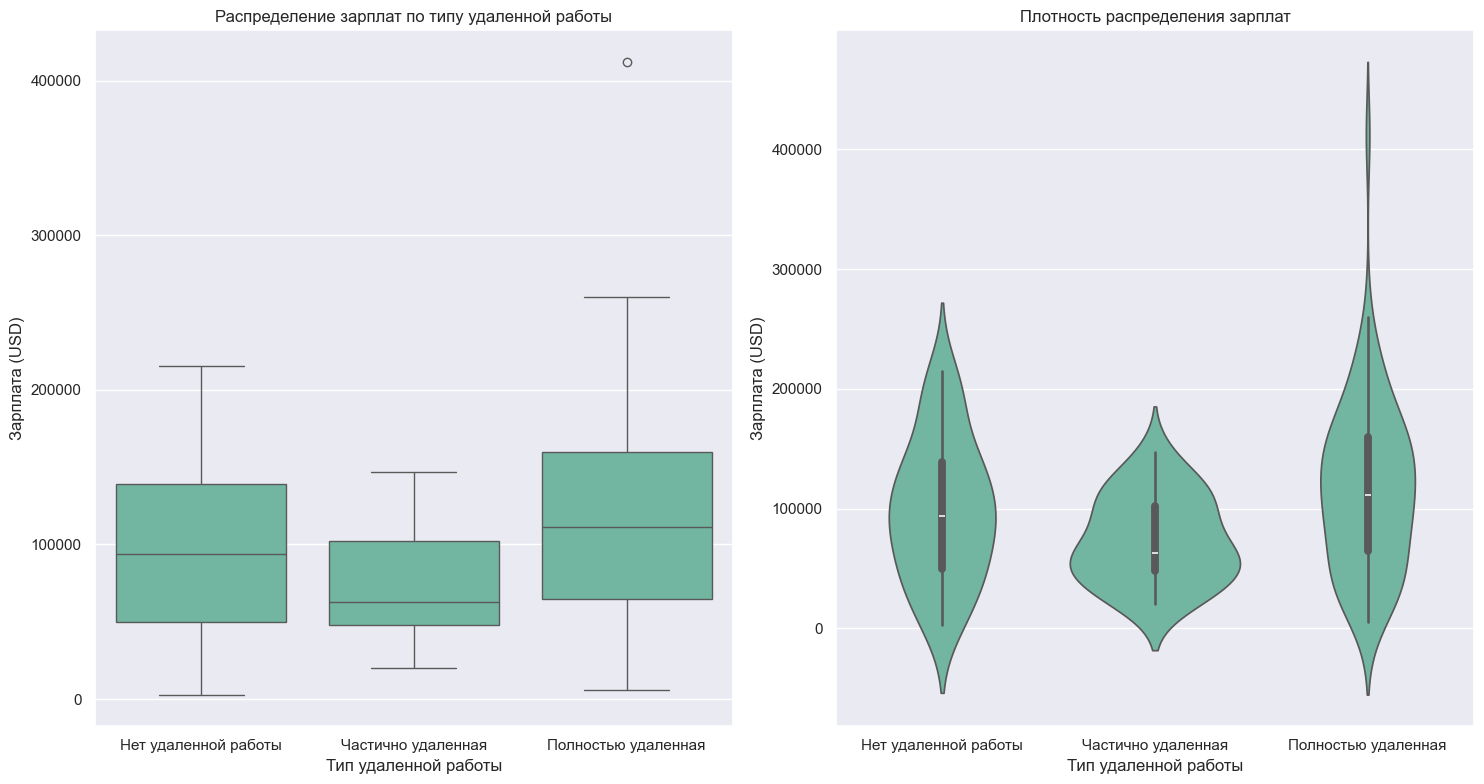

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,38,"98,445","58,648","2,859","49,781","93,582","139,050","215,300"
1,24,"73,828","36,204","20,171","47,784","62,726","102,250","147,000"
2,68,"116,485","70,908","5,679","64,420","111,500","160,000","412,000"


In [33]:
# Распределение зарплат по типу выполнения работы:
# 0 — удалённой работы нет (менее 20 %);
# 1 — частично удалённая работа;
# 2 — полностью удалённая работа (более 80 %).
df_numeric= df_numeric[df_numeric['job_title']== 'Data Scientist']
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Первый график - boxplot для сравнения распределений
sns.boxplot(data=df_numeric, x='remote_ratio', y='salary_in_usd', ax=axes[0])
axes[0].set_title('Распределение зарплат по типу удаленной работы')
axes[0].set_xlabel('Тип удаленной работы')
axes[0].set_ylabel('Зарплата (USD)')

# Устанавливаем подписи для осей X
remote_labels = {0: 'Нет удаленной работы', 1: 'Частично удаленная', 2: 'Полностью удаленная'}
axes[0].set_xticklabels([remote_labels[int(x.get_text())] for x in axes[0].get_xticklabels()])

# Второй график - violin plot для более детального распределения
sns.violinplot(data=df_numeric, x='remote_ratio', y='salary_in_usd', ax=axes[1])
axes[1].set_title('Плотность распределения зарплат')
axes[1].set_xlabel('Тип удаленной работы')
axes[1].set_ylabel('Зарплата (USD)')
axes[1].set_xticklabels([remote_labels[int(x.get_text())] for x in axes[1].get_xticklabels()])

plt.tight_layout()
plt.show()
# статистические данные
styled_stats = (df_numeric.groupby('remote_ratio')['salary_in_usd']
                .describe()
                .round(0)
                .style
                .format('{:,.0f}'))

display(styled_stats)



#### Основные выводы:

 1. **Полностью удаленная работа оплачивается выше**
- Средняя зарплата: **$116,485** (самая высокая)
- Медианная зарплата: **$111,500**
- Максимальная зарплата достигает **$412,000**

 2. **Работа без удаленного формата имеет стабильные показатели**
- Средняя зарплата: **$98,445**
- Медианная зарплата: **$93,582**
- Наименьший разброс данных (std = $58,648)

3. **Частично удаленная работа имеет самую низкую оплату**
- Средняя зарплата: **$73,828** (на 25% ниже полностью удаленной)
- Медианная зарплата: **$62,726**
- Наименьшее количество наблюдений (n=24)

4. **Распределение зарплат показывает интересные тенденции**
- **Полностью удаленные** работники имеют наибольший разброс зарплат (std = $70,908)
- **Без удаленки** - наиболее стабильный и предсказуемый доход
- **Частично удаленные** позиции могут быть менее квалифицированными или младшими

#### Возможные причины:
- Полностью удаленные позиции требуют высокой самодисциплины и могут быть более senior-уровня
- Компании экономят на office space и могут перераспределять средства в зарплаты
- Глобальный рынок труда для удаленных работников более конкурентный

## 5. Статистический анализ


**Категориальные:**
- experience_level   (4) опыт работы 
- job_title         (50) - должность 
- company_location  (50) - местоположение компании
- company_size      (3) -  - размер компании 

**Количественные:**
- work_year         (3)   - год работы  
- salary_in_usd     (369)   - зарплата в $
- remote_ratio      (3)   -  формат работы 





### *5.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?*





        - тип признаков- количесвенный
        - группы независимы
        - сравниваемых  группы - 3 
**Общая гипотеза**

*Нулевая гипотеза (H₀)*:  Средние (или медианные) зарплаты специалистов Data Science не различаются между 2020, 2021 и 2022 годами. 

*Альтернативная гипотеза (H₁)*: Средняя зарплата зарплаты специалистов Data Science  различаются между 2020, 2021 и 2022 годами.


**Гипотезы для попарных сравнений (Манна-Уитни)**

*Для сравнения 2020 vs 2021:*

- Нулевая гипотеза (H₀): Медианная зарплата в 2020 году равна или больше медианной зарплаты в 2021 году.
- Альтернативная гипотеза (H₁): Медианная зарплата в 2020 году меньше медианной зарплаты в 2021 году (односторонняя).

*Для сравнения 2021 vs 2022:*
- Нулевая гипотеза (H₀): Медианная зарплата в 2021 году равна или больше медианной зарплаты в 2022 году.
- Альтернативная гипотеза (H₁): Медианная зарплата в 2021 году меньше медианной зарплаты в 2022 году.

*Итоговая гипотеза о ежегодном росте*
- Нулевая гипотеза (H₀): Ежегодного роста зарплат не наблюдается.
- Альтернативная гипотеза (H₁): Наблюдается статистически значимый ежегодный рост зарплат.



#### **Проверка на нормальность** 
 
 

In [34]:
#фильтруем датафрейм для стат анализа
data_DS= data[data['job_title']== 'Data Scientist']

# создаем новые признаки для проверки на нормальность
salary_2020 = data_DS[data_DS['work_year'] == 2020]['salary_in_usd']
salary_2021 = data_DS[data_DS['work_year'] == 2021]['salary_in_usd']
salary_2022 = data_DS[data_DS['work_year'] == 2022]['salary_in_usd']

#проводим тест шапиро-уилка
print('Для 2020:')
result= stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2020:')
result= stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2020:')
result= stats.shapiro(salary_2020)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


#### *Выбираем подходящий статистический тест* 


В таком случае будем импользовать метод Краскела-Уоллиса для общего сравнения, и попарное сравнение манна-уитни

In [35]:


# Уровень значимости
alpha = 0.05
num_comparisons = 2

print("1. ОБЩЕЕ СРАВНЕНИЕ (Тест Крускала-Уоллиса):")
_, p_kw = kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p_kw)  
print()

# Поправка Бонферрони
bonferroni_alpha = alpha / num_comparisons

print(f"2. ПРОВЕРКА ЕЖЕГОДНОГО РОСТА (Тест Манна-Уитни с поправкой Бонферрони):")

# 2020 vs 2021
_, p_20_21 = mannwhitneyu(salary_2020, salary_2021, alternative='less')
p_20_21_corrected = p_20_21 * num_comparisons
print("2020 < 2021 (скорректированное):")
decision_hypothesis(p_20_21_corrected)
print(f"(исходное p-value: {p_20_21:.4f})")

# 2021 vs 2022  
_, p_21_22 = mannwhitneyu(salary_2021, salary_2022, alternative='less')
p_21_22_corrected = p_21_22 * num_comparisons
print("2021 < 2022 (скорректированное):")
decision_hypothesis(p_21_22_corrected)
print(f"(исходное p-value: {p_21_22:.4f})")

# Общий вывод о ежегодном росте
print("\n3. ИТОГОВЫЙ ВЫВОД:")
if p_20_21_corrected <= alpha and p_21_22_corrected <= alpha:
    print("🎯 Наблюдается статистически значимый ЕЖЕГОДНЫЙ рост зарплат (с поправкой Бонферрони)!")
elif p_kw < alpha:
    print("⚠️ Есть различия между годами, но не последовательный ежегодный рост (с поправкой Бонферрони)")
else:
    print("❌ Статистически значимых различий между годами не обнаружено")

1. ОБЩЕЕ СРАВНЕНИЕ (Тест Крускала-Уоллиса):
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.

2. ПРОВЕРКА ЕЖЕГОДНОГО РОСТА (Тест Манна-Уитни с поправкой Бонферрони):
2020 < 2021 (скорректированное):
p-value = 1.411
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
(исходное p-value: 0.7054)
2021 < 2022 (скорректированное):
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
(исходное p-value: 0.0000)

3. ИТОГОВЫЙ ВЫВОД:
⚠️ Есть различия между годами, но не последовательный ежегодный рост (с поправкой Бонферрони)


#### **ВЫВОД**
Нет оснований полагать,  что наблюдается ежегодный рост зарплат для специалистов DS,  различия есть между годами, но не последовательный ежегодный рост

### *5.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?*


- *Нулевая гипотеза(H0)*: Зарплата DS меньше или равна  зарплате DE
- *Альтернативная(Н1)*: Зарплата DS больше зарплаты DE


        - Сравниваемых  групп -2
        - группы независимы
        - признак Salary_in_usd количественный

In [36]:

# Фильтруем данные: оставляем только Data Scientist и Data Engineer за 2022 год
filtered_df = data[(data['work_year'] == 2022)].copy() 

 Проверка на нормальность 

In [37]:

#проверка на нормальность 

DS  = filtered_df[filtered_df['job_title'] == 'Data Scientist']['salary_in_usd']
DE = filtered_df[filtered_df['job_title'] == 'Data Engineer']['salary_in_usd']

# проводим тест Shapiro
print(' Для DS')
result = stats.shapiro(DS)
decision_normality(result[1])

print('Для DE')
result = stats.shapiro(DS)
decision_normality(result[1])

 Для DS
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DE
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [38]:
#проводим тест на равенство дисперсий
levene_test = stats.levene(DS, DE)
print(f"Levene's test p-value: {levene_test.pvalue}")

if levene_test.pvalue > 0.05:
    print("Дисперсии можно считать равными. Используем t-тест с равными дисперсиями.")
    equal_var = True
else:
    print("Дисперсии значимо различаются. Используем t-тест Уэлча (с неравными дисперсиями).")
    equal_var = False

Levene's test p-value: 0.7765056650239544
Дисперсии можно считать равными. Используем t-тест с равными дисперсиями.


#### Для проверки нашей гипотезу подойдет тест t-test

In [39]:
_ ,p = stats.ttest_ind(DS, DE , alternative='greater')
decision_hypothesis(p)

p-value = 0.241
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


#### **ВЫВОД**
На основе имеющихся данных за 2022 год нельзя сделать вывод, что зарплата Data Scientist статистически значимо превышает зарплату Data Engineer.\
Статистические данные не подтверждают альтернативную гипотезу о том, что Data Scientist получают больше.

### *5.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?*


        - Тип признака 'company_size' - был закодирован и теперь имеет количественный тип
        - 3 сравниваемых группы
        - Группы независимы

**Общая проверка на наличие различий** 

*Нулевая гипотеза (H₀):* Медианные зарплаты специалистов Data Scientist одинаковы для компаний разного размера (S, M, L). Распределения зарплат во всех группах идентичны.

*Альтернативная гипотеза (H₁):* Медианные зарплаты специалистов Data Scientist не все одинаковы среди компаний разного размера. По крайней мере, одна группа отличается от других.

**Набор гипотез для попарного сравнения**

*Пара 1: Малые (S) vs Средние (M) компании*

- H₀: Медианные зарплаты Data Scientist в малых и средних компаниях одинаковы

- H₁: Медианные зарплаты Data Scientist в малых и средних компаниях различаются

*Пара 2: Малые (S) vs Крупные (L) компании*

- H₀: Медианные зарплаты Data Scientist в малых и крупных компаниях одинаковы

- H₁: Медианные зарплаты Data Scientist в малых и крупных компаниях различаются

*Пара 3: Средние (M) vs Крупные (L) компании*

- H₀: Медианные зарплаты Data Scientist в средних и крупных компаниях одинаковы

- H₁: Медианные зарплаты Data Scientist в средних и крупных компаниях различаются


In [40]:
# Проверяем признаки на нормальное распределение

#фильтруем по специалистам
data_DS= data[data['job_title']== 'Data Scientist']

# Маленькие компании 
little_company = data_DS[data_DS['company_size'] == 'S']['salary_in_usd']

# Средние компании
middle_company = data_DS[data_DS['company_size'] == 'M']['salary_in_usd']

# Крупные компании
big_company = data_DS[data_DS['company_size'] == 'L']['salary_in_usd']

print('Для маленьких  компаний')
result= stats.shapiro(little_company)
decision_normality(result[1])

print('Для средних  компаний')
result= stats.shapiro(middle_company)
decision_normality(result[1])

print('Для больших  компаний')
result= stats.shapiro(big_company)
decision_normality(result[1])



Для маленьких  компаний
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средних  компаний
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для больших  компаний
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Один из признаков распределен отлично от нормального,  воспользуемся непараметрическими тестами

Применим метод Краскела-Уоллиса и  Манна- Уитни для статистических  тестов 

In [41]:


#Метод Краскела-Уоллиса на равенство 
print(' Проводим тест Краскела-Уоллиса на равенство признаков ')
_ , p = stats.kruskal(little_company, middle_company, big_company)
decision_hypothesis(p)
print()

#Метод Манна -уитни для более подробного статистического анализа 
# Поправка Бонферрони для 3 сравнений
num_comparisons = 3
alpha_corrected = alpha / num_comparisons

print("ПОПАРНОЕ СРАВНЕНИЕ ГРУПП (Манна-Уитни с поправкой Бонферрони)")
print("=" * 60)


groups = {
    "Маленькие компании": little_company,
    "Средние компании": middle_company,
    "Крупные компании": big_company
}
# Создаем все возможные пары для сравнения
pairs = list(combinations(groups.items(), 2))

for (name1, data1), (name2, data2) in pairs:
    # Формулируем гипотезы для этой пары
    print(f"Сравнение: {name1} vs {name2} ")
    # Проводим статистический тест
    _ , p = mannwhitneyu(data1, data2, alternative='two-sided')
    
    print(f"p-value = {p:.4f}")
    print(f"Критический уровень значимости (с поправкой Бонферрони) = {alpha_corrected:.4f}")
    
    # Принимаем решение
    if p < alpha_corrected:
        print(f"✅ ОТВЕРГАЕМ H₀: Есть статистически значимые различия между {name1} и {name2}")
    else:
        print(f"❌ НЕ ОТВЕРГАЕМ H₀: Нет статистически значимых различий между {name1} и {name2}")
    
    print("-" * 50)

print(f"\nОбщее примечание: Уровень значимости α = {alpha} скорректирован до {alpha_corrected:.4f} по Бонферрони")
    

 Проводим тест Краскела-Уоллиса на равенство признаков 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.

ПОПАРНОЕ СРАВНЕНИЕ ГРУПП (Манна-Уитни с поправкой Бонферрони)
Сравнение: Маленькие компании vs Средние компании 
p-value = 0.0000
Критический уровень значимости (с поправкой Бонферрони) = 0.0167
✅ ОТВЕРГАЕМ H₀: Есть статистически значимые различия между Маленькие компании и Средние компании
--------------------------------------------------
Сравнение: Маленькие компании vs Крупные компании 
p-value = 0.0026
Критический уровень значимости (с поправкой Бонферрони) = 0.0167
✅ ОТВЕРГАЕМ H₀: Есть статистически значимые различия между Маленькие компании и Крупные компании
--------------------------------------------------
Сравнение: Средние компании vs Крупные компании 
p-value = 0.0483
Критический уровень значимости (с поправкой Бонферрони) = 0.0167
❌ НЕ ОТВЕРГАЕМ H₀: Нет статистически значимых различий между Ср

#### **ВЫВОД**

ПО тесту Краскела-Уоллиса на равенство признаков,  у нас нет оснований отвергать нулевую гипотезу. Медианные зарплаты специалистов Data Scientist одинаковы для компаний разного размера (S, M, L). Распределения зарплат во всех группах идентичны


По попарному сравнению групп (Манна-Уитни с поправкой Бонферрони): 
- Между небольшими и средними компаниями есть статистически значимые различия
- между небольшими и крупными компаниями так же есть статистически значимые различия
- между средними и крупными компаниями нет статистически значимых различий

### *5.4 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?*

Будем использовать Критерий хи-квадрат для статистического теста 

- Нулевая гипотеза (H₀): Распределение компаний, в которых есть должности Data Scientist и/или Data Engineer, не зависит от размера компании. Маленькие, средние и большие компании с одинаковой вероятностью имеют эти должности. 
- Альтернативная гипотеза (H₁): Распределение компаний, в которых есть должности Data Scientist и/или Data Engineer, зависит от размера компании. Вероятность найти DS'а или DE'а по-разному в компаниях разного размера.

In [42]:
# Фильтруем данные только по интересующим нас должностям
filtered_df = data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]

# Создаем таблицу сопряженности
table = pd.crosstab(filtered_df['company_size'], filtered_df['job_title'])
_ , p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Поскольку p-значение (0.005) меньше уровня значимости (0.05), мы отвергаем нулевую гипотезу в пользу альтернативной.

Это означает, что существует статистически значимая связь между размером компании и наличием должностей Data Scientist и Data Engineer.

### *5.5 Наблюдается ли  зависимость между  опытом работы и средним уровнем дохода у специалистов Data Science*





- **Нулевая гипотеза:** При повышении опыта работы не изменяется заработная плата 
- **Альтернативная гипотеза:** При повышении опыта работы изменяется заработная плата 

experience_level- имеет 3 признака 0, 1,2, 3( джуниор ,  мидл , сеньер,  директор )
salary_in_usd -ЗП в долларах

In [43]:
# фильтруем данные по профессии DS
data_DS= data[data['job_title'] == 'Data Scientist']

#фильтруем данные по опыту работы  
df_en= data_DS[data_DS['experience_level']=='EN']['salary_in_usd']
df_mi= data_DS[data_DS['experience_level']== 'MI']['salary_in_usd']
df_se= data_DS[data_DS['experience_level']== 'SE']['salary_in_usd']

# используем тест Краскела для проверки на равенство 
_ , p = stats.kruskal(df_en, df_mi,df_se)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [44]:
corr, p_value = stats.spearmanr(data_DS['experience_level'], data_DS['salary_in_usd'])
decision_hypothesis(p)



p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


ПРи повышении опыта у нас нет оснований утвержадть что заработная плата у специалиста DS изменяется(Увеличивается или уменьшается). Это может говорить о том,  что при повышении опыта у сотрудников возможна смена названия профессии.Из статистичекого теста можно сделать вывод, прямой зависимости над опытом и ЗП DS не наблюдается или она слишком мала 

# ***ОБЩИЙ ВЫВОД***

## 1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
1.  **Визуальный анализ:**

Наблюдается **не линейный ежегодный рост, а двухэтапная динамика**:
- **2020-2021**: Стагнация/коррекция (возможно, из-за притока новых специалистов)
- **2021-2022**: Резкий скачок (удвоение зарплат)
Как итог, наблюдается значительный рост зарплат специалистов DS за период 2020-2022 годов, однако этот рост был неравномерным и произошел преимущественно за счет резкого увеличения в 2022 году

2. **Статистический тест:**

Нет оснований полагать,  что наблюдается ежегодный рост зарплат для специалистов DS,  различия есть между годами, но не последовательный ежегодный рост

## 2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
1.  **Визуальный анализ:**

Data Scientist имеют небольшое, но стабильное преимущество в зарплатах, особенно на начальных и средних позициях, однако для senior-уровня разница практически стирается.

2. **Статистический тест:**

На основе имеющихся данных за 2022 год нельзя сделать вывод, что зарплата Data Scientist статистически значимо превышает зарплату Data Engineer.\
Статистические данные не подтверждают альтернативную гипотезу о том, что Data Scientist получают больше.

## 3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
1.  **Визуальный анализ:**

Средние компании платят Data Scientist больше всех - на 22% больше, чем крупные компании, и в 2.4 раза больше, чем маленькие.
- Маленькие компании (S): Низкие зарплаты (ограниченные ресурсы)
- Средниe компании (M): Наивысшие зарплаты (зона максимального роста)
- Крупные компании (L): Зарплаты ниже средних (возможно, насыщение рынка)

2. **Статистический тест:**

ПО тесту Краскела-Уоллиса на равенство признаков,  у нас нет оснований отвергать нулевую гипотезу. Медианные зарплаты специалистов Data Scientist одинаковы для компаний разного размера (S, M, L). Распределения зарплат во всех группах идентичны
По попарному сравнению групп (Манна-Уитни с поправкой Бонферрони): 
- Между небольшими и средними компаниями есть статистически значимые различия
- между небольшими и крупными компаниями так же есть статистически значимые различия
- между средними и крупными компаниями нет статистически значимых различий

## 4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
1.  **Визуальный анализ:**

2. **Статистический тест:**

Существует статистически значимая связь между размером компании и наличием должностей Data Scientist и Data Engineer.


#### **1. Размер компании: Нелинейная зависимость**
Результаты показывают, что зависимость зарплаты от размера компании не является линейной ("чем больше компания, тем выше зарплата").

*   **Наибольшие зарплаты наблюдаются в компаниях среднего размера.** Они предлагают зарплаты в среднем на **22% выше**, чем крупные компании, и в **2.4 раза выше**, чем малые предприятия.
*   **Статистическая значимость:**
    *   **Значимая разница** наблюдается между малыми и средними, а также между малыми и крупными компаниями.
    *   **Незначимая разница** между средними и крупными компаниями.

**Вывод:** Для специалиста DS переход из малой компании в среднюю или крупную ведет к существенному росту дохода. Однако "потолок" зарплат может находиться именно в сегменте средних, возможно, более гибких и амбициозных компаний.

---

#### **2. Опыт работы: Самый мощный драйвер роста**
Опыт оказывает наиболее сильное влияние на уровень дохода, однако картина роста не всегда однородна.

*   **Качественный скачок:** Переход с уровня **Entry-level (EN)** к **Mid-level (MI)** сопровождается увеличением зарплаты в **2-3 раза** (с ~$38-68k до ~$86-101k).
*   **Дальнейший рост:** Переход от **Mid-level (MI)** к **Senior-level (SE)** дает увеличение еще в **1.5-2 раза** (до ~$152-154k).
*   **Важное статистическое уточнение:** Несмотря на очевидный количественный рост, **тест Краскела-Уоллиса не выявил статистически значимых различий** между всеми группами опыта в целом. Это может указывать на две возможные причины:
    1.  **Смена роли:** При достижении определенного уровня опыта специалисты часто меняют не просто уровень, а саму должность (например, уходя в руководящие роли Principal DS, ML Engineer, Manager), которые не всегда попадают в выборку "Data Scientist".
    2.  **Высокий разброс данных:** Зарплаты внутри одной группы опыта (особенно среди senior-специалистов) могут сильно варьироваться в зависимости от других факторов (например, стека технологий, индустрии), "размывая" статистическую значимость.

**Вывод:** Опыт критически важен для роста зарплаты, особенно на ранних и средних этапах карьеры. На уровне Senior влияние других факторов (специализация, менеджерские навыки) становится сравнимым с опытом.

---

#### **3. Внешние факторы: Рынок труда и глобальные события**
Динамика зарплат четко отражает конъюнктуру рынка труда, подверженную влиянию внешних событий.

*   **2020 год ("Эффект пандемии"):** Резкий всплеск спроса на цифровизацию и Data Science на фоне кризиса привел к **росту зарплат** как инструменту привлечения дефицитных кадров.
*   **2021 год ("Коррекция"):** Рынок начал насыщаться, компании адаптировались к новым условиям, что, вероятно, привело к некоторому **снижению или стагнации зарплатных предложений**.
*   **2022 год ("Стабилизация"):** Рынок нашел новый баланс, и зарплаты **стабилизировались** на новом, установившемся уровне.

**Вывод:** Зарплаты в DS являются высокочувствительным индикатором спроса и предложения на рынке труда, который, в свою очередь, зависит от глобальных экономических трендов.

---

### **Общий итог**

На зарплату специалиста Data Science влияет комплекс факторов:
1.  **Карьерный рост (опыт)** — ключевой двигатель, особенно на старте.
2.  **Выбор работодателя (размер компании)** — максимальный доход часто не в самых крупных корпорациях, а в растущих средних компаниях.
3.  **Рыночный контекст (время)** — глобальные события и циклы рынка труда могут существенно корректировать зарплатные ожидания.